### Start-up

Run this cell cell only befor the first execution, or after you made changes to ```cubes_e2e.py```. 

In [1]:
%run cubes_e2e_refresh.py

Uncomment this cell to enable plot interactivity.

In [2]:
#%matplotlib notebook

Uncomment this cell to perform memory checks.

In [3]:
#%load_ext memory_profiler

### Input spectra

Select the spectral template for the science target: ```flat``` for a flat spectrum, ```PL``` for a power-law, or ```custom``` for a custom spectrum to be read from a file. If you select ```custom```, please provide the path to the file as well. Wavelengths in the file must be expressed in Angstrom.


**NB**: run this cell if you run the one at the top.

In [4]:
sim.spec_templ = 'custom'  # Template 
sim.spec_file = 'Science_Spectra/gal_2.5_1_0.1_0.1_20.txt'  # Path to file

Specify the ```AB``` or ```Vega``` magnitude of the target in a given photometric band. Available bands are ```u```, ```g```, ```r```, ```i```, ```z``` for the ```AB``` system and ```U```, ```B```, ```V```, ```R```, ```I```, ```J```, ```H```, ```K``` for the ```Vega``` system. The magnitude will be converted into a photon flux density at the central wavelength of the band and use to rescale the spectral template.

**NB**: ```AB``` magnitudes are not currently supported. Use ```Vega``` instead.

**NB**: be sure that the band you choose is wholly covered by your spectral template.

In [5]:
sim.mag_syst = 'Vega'  # System
sim.mag_band = 'B'  # Band
sim.targ_mag = 12  # Magnitude

Only for extragalactic spectra: provide an emission redshift and chose how to model the IGM absorption (```simple``` for a simple integration of the Lyman-alpha curve of growth; ```inoue``` for the more accurate formulae from Inoue et al. 2014, covering all the Lyman series).

**NB**: Be sure that ```zem``` is set to ```None``` if you are **not** using an extragalactic spectrum.

In [6]:
sim.zem = None  # Emission redshift
sim.igm_abs = None  # IGM absorption

Adjust the atmospheric parameters and compute the spectrum of the sky background with SkyCalc. 

**NB**: If SkyCalc fails, a flat background spectrum with a given magnitude will be created later, together with the target spectrum.

In [7]:
sim.airmass = 1.16  # Airmass
sim.pwv = 2.5 # Precipitable water vapor
sim.moond = 0  # Days from new moon
try:
    %run -i SkyCalc_Call.py
except:
    sim.bckg_mag = 22.5 # Background magnitude

Sky spectrum created and saved in SkyCalc_input_NEW_Out.fits.


Finally, plot the input spectra of target and background for a given exposure time. Optionally save the target spectrum in a format accepted by the CUBES ETC 

**NB**: to properly save the spectrum, ```sig.mag_syst``` and ```sig.mag_band``` above must be ```Vega``` and ```V```, respectively. ```sim.qso_zem``` must be above 1 to have enough flux in the Vega V band (and avoid normalization issues).

Photons collected.
Input spectra created.
Sky spectrum imported from SkyCalc_input_NEW_Out.fits.


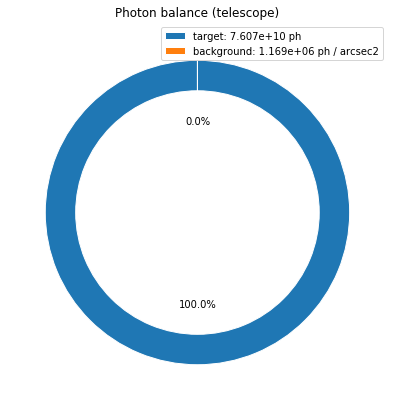

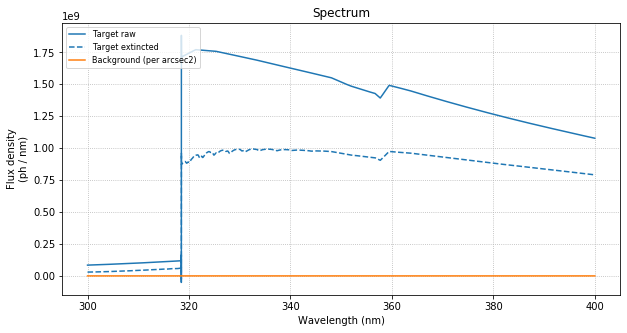

In [8]:
sim.texp = 3600*au.s  # Exposure time
sim.spec_in()
#%mprun -f sim.spec_in sim.spec_in()  # Only for memory checks

### PSF and slices

Define a function for the PSF of the target in the sky (```tophat```  or ```gaussian```). The ```seeing``` parameters provides the radius of the ```tophat``` function or the FWHM of the ```gaussian``` function.

In [9]:
sim.psf_func = 'gaussian'  # Function to represent the PSF
sim.seeing = 0.87*au.arcsec  # Seeing

Design the slices onto the PSF, specifying their number and size.

Slices designed on field.     


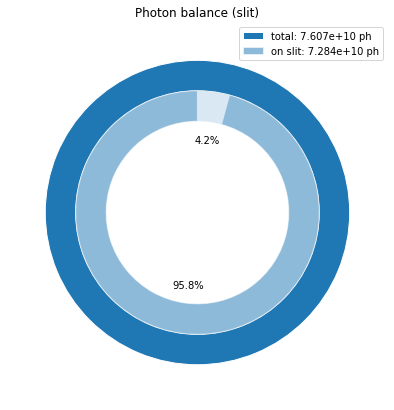

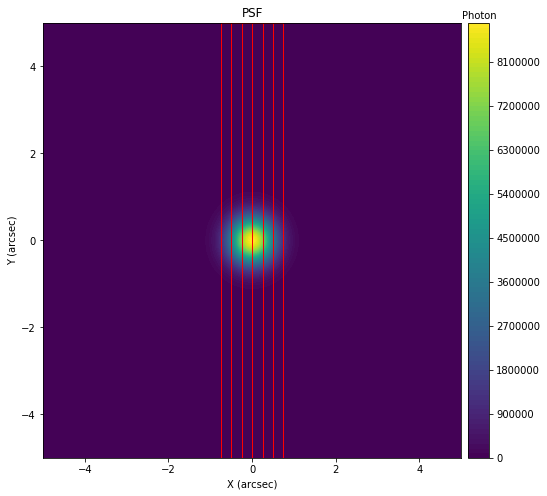

In [10]:
sim.slice_n = 6  # Number of slices
sim.slice_length = 10*au.arcsec  # Length of the slice
sim.slice_width = 0.25*au.arcsec  # Width of the slice
sim.psf()
#%mprun -f sim.psf sim.psf()  # Only for memory checks

### Spectral format

Specify the characteristics of the CCDs, including the size and binning of pixels.

**NB**: The CCDs are assumed to be identical in all arms.

In [11]:
sim.ccd_gain = 1.1*au.photon/au.adu  # Gain (i.e. conversion from ADU to photons)
sim.ccd_ron = 2*au.photon / sim.ccd_gain  # Read-out noise (in ADU)
sim.ccd_dark = 3*au.photon/au.h / sim.ccd_gain  # Dark current (in ADU per unit time)
sim.ccd_xsize = 6144*au.pixel  # X size of the CCD 
sim.ccd_ysize = 6144*au.pixel  # Y size of the CCD
sim.pix_xsize = 15*au.micron  # X size of the pixels
sim.pix_ysize = 15*au.micron  # Y size of the pixels
sim.ccd_xbin = 1  # X binning of the CCD
sim.ccd_ybin = 1  # Y binning of the CCD

Choose the number of arms (2 or 3). Optimal values for the dichroich wavelength(s) and the shift of the CCD edges with respect to the dichroich wavelength(s) for a 6k × 6k CCD are given, but you can fine-tune them too (especially if you choose a different CCD size).

In [12]:
sim.arm_n = 2  # Number of arms
if sim.arm_n == 1:
    sim.wave_d = []*au.nm  # Wavelength of dichroich
if sim.arm_n == 2:
    sim.wave_d = [347.5]*au.nm  # Wavelength of dichroich
    sim.wave_d_shift = 2*au.nm  # Shift of the CCD edges w.r.t. the dichroich wavelength
if sim.arm_n == 3:
    sim.wave_d = [335, 362.5]*au.nm  # Wavelengths of dichroichs
    sim.wave_d_shift = 12*au.nm  # Shift of the CCD edges w.r.t. the dichroich wavelengths

Adjust the nominal efficiency of the different optical elements.

In [13]:
sim.eff_wave = [300, 320, 340, 360, 380, 400]*au.nm  # Wavelengths used to model efficiency

# Flat efficiencies
#sim.eff_adc = [0.96, 0.96, 0.96, 0.96, 0.96, 0.96]  # ADC efficiency
#sim.eff_slc = [0.98, 0.98, 0.98, 0.98, 0.98, 0.98]  # Slicer efficiency
#sim.eff_dch = [0.96, 0.96, 0.96, 0.96, 0.96, 0.96]  # Dichroics efficiency
#sim.eff_spc = [0.94, 0.94, 0.94, 0.94, 0.94, 0.94]  # Spectrograph efficiency
#sim.eff_grt = [0.90, 0.90, 0.90, 0.90, 0.90, 0.90]  # Grating efficiency
#sim.eff_ccd = [0.85, 0.85, 0.85, 0.85, 0.85, 0.85]  # CCD QE

# Shaped efficiencies
sim.eff_adc = [0.88, 0.94, 0.96, 0.96, 0.95, 0.94]  # ADC efficiency
sim.eff_slc = [0.94, 0.97, 0.98, 0.98, 0.97, 0.96]  # Slicer efficiency
sim.eff_dch = [0.88, 0.94, 0.96, 0.96, 0.95, 0.94]  # Dichroics efficiency
sim.eff_spc = [0.79, 0.89, 0.94, 0.94, 0.92, 0.90]  # Spectrograph efficiency
if sim.arm_n == 1:
    sim.eff_grt = [0.75, 0.86, 0.92, 0.89, 0.83, 0.74]  # Grating efficiency
if sim.arm_n == 2:
    sim.eff_grt = [0.85, 0.92, 0.90, 0.89, 0.92, 0.88]  # Grating efficiency
if sim.arm_n == 3:
    sim.eff_grt = [0.86, 0.92, 0.90, 0.91, 0.92, 0.90]  # Grating efficiency
sim.eff_ccd = [0.55, 0.75, 0.85, 0.85, 0.80, 0.78]  # CCD QE

Define the instrument resolution and the spatial scale.

**NB**: The sampling is the wavelength range of **non-binned** pixels. It will be converted internally to the sampling of binned pixels.

In [14]:
if sim.arm_n == 1:
    sim.disp_wave = [[300, 320, 340, 360, 380, 400]]*au.nm  # Wavelengths used to model dispersion
    sim.disp_sampl = [[8.7e-3, 8.5e-3, 8.3e-3, 8.1e-3, 7.9e-3, 7.7e-3]]*au.nm/au.pixel  # Dispersion sampling on CCD
    sim.disp_resol = [[1.45e4, 1.65e4, 1.85e4, 2.05e4, 2.25e4, 2.45e4]]  # Resolution
if sim.arm_n == 2:
    sim.disp_wave = [[300, 320, 340], [360, 380, 400]]*au.nm  # Wavelengths used to model dispersion
    sim.disp_sampl = [[8.1e-3, 7.75e-3, 7.4e-3], [8.8e-3, 8.4e-3, 8.0e-3]]*au.nm/au.pixel  # Dispersion sampling on CCD
    sim.disp_resol = [[1.7e4, 1.9e4, 2.1e4], [1.8e4, 2.0e4, 2.2e4]]  # Resolution
if sim.arm_n == 3:
    sim.disp_wave = [[305, 325], [340, 360], [375, 395]]*au.nm  # Wavelengths used to model dispersion
    sim.disp_sampl = [[8.25e-3, 8.0e-3], [8.45e-3, 8.1e-3], [8.65e-3, 8.2e-3]]*au.nm/au.pixel  # Dispersion sampling on CCD
    sim.disp_resol = [[1.7e4, 1.9e4], [1.85e4, 2.05e4], [2.0e4, 2.2e4]]  # Resolution    
sim.spat_scale = 0.25*au.arcsec/(30*au.micron)  # Spatial scale

Finally, set a value for the gap between the slices and display the spectral format.

**NB**: The sampling in the plot is that of **binned** pixels.

Slices projected onto arms.       


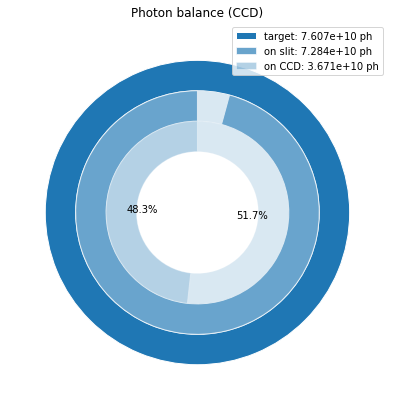

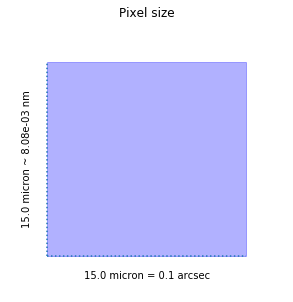

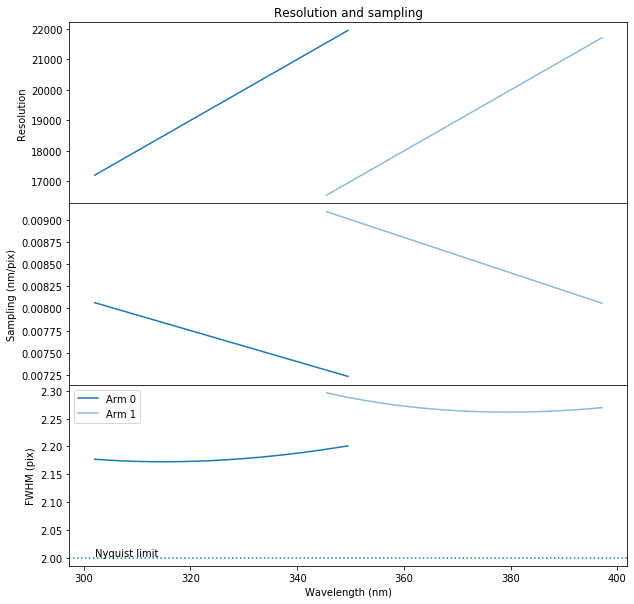

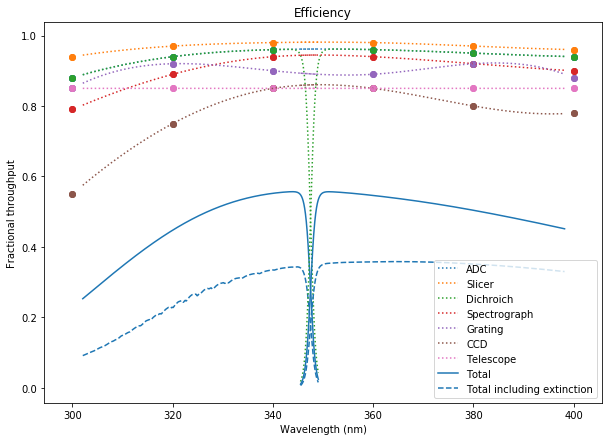

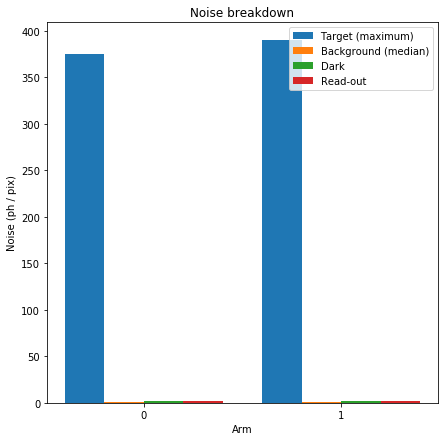

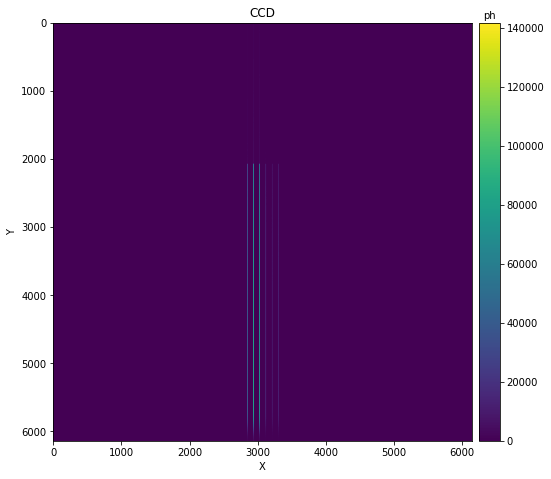

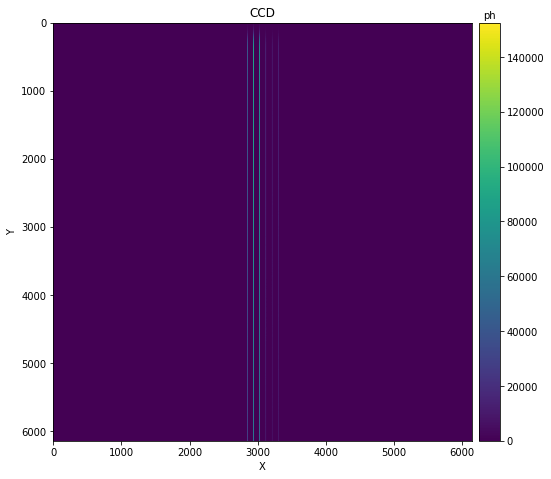

In [15]:
sim.slice_gap = 10*au.pixel  # Gap between the slices
sim.ccd()
#%mprun -f sim.ccd sim.ccd()  # Only for memory checks

### Output spectrum

Select the extraction method: ```sum``` for a simple boxcar summation, ```opt``` for Horne-like optimal extraction. 

NB: ```opt``` has not been thoroughly tested and is very time-consuming.

In [16]:
sim.extr_func = 'sum'  # Function for extracting the spectrum

Choose the sampling to compute the signal-to-noise ratio on the extracted spectrum.

In [17]:
sim.snr_sampl = 1*au.nm  # Data points per SNR point

Finally, extract the spectrum and display it:

Slices extracted from arms.       


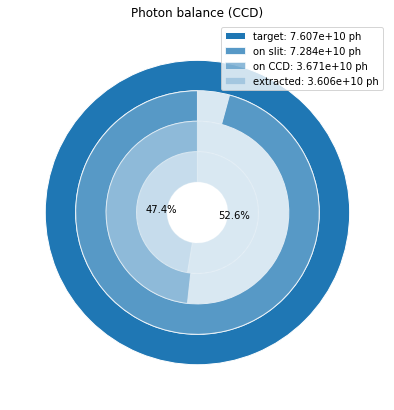

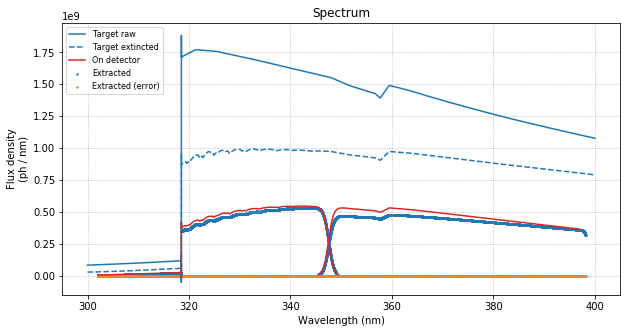

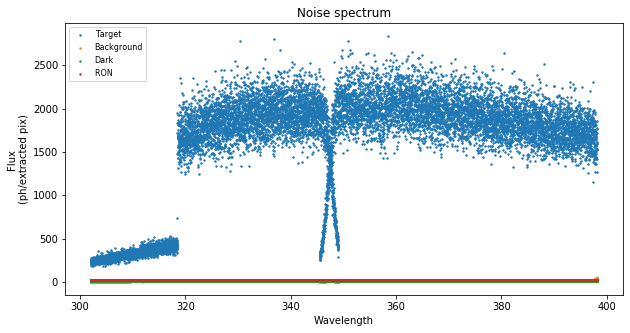

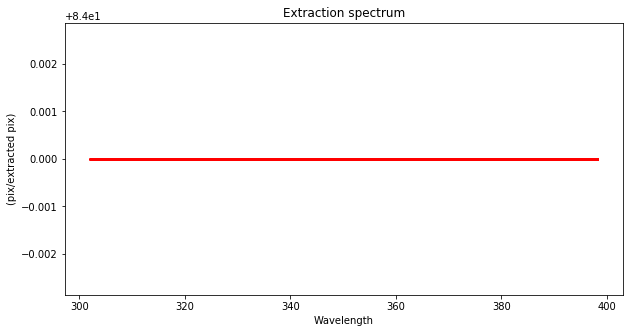

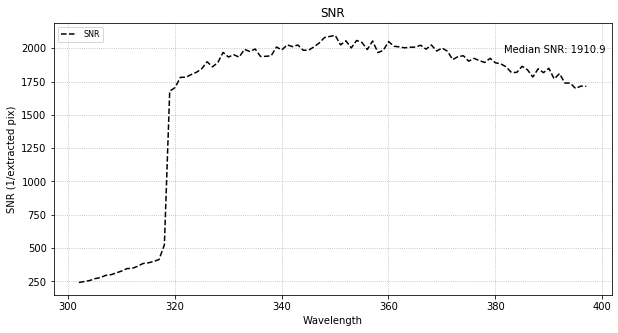

In [18]:
sim.spec_draw()
#%mprun -f sim.spec_draw sim.spec_draw()  # Only for memory checks